In [ ]:
#import statements

import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from rich import print

In [2]:
#Reading in ordinace data
ord = pd.read_excel('/Users/gzuckerm/Desktop/eagle_transfers/from_eagle/Supply_Curves/FY26/COMPASS/Solar Ordinances 2025.xlsx', skiprows=1)

In [4]:
#Examining the numerical ordiances
numeric_count = pd.to_numeric(ord.Value, errors='coerce').notna().sum()
print(f"[bold]Number of rows with numeric Value: {numeric_count} out of {len(ord)} total rows.[/bold]")

Number of rows with numeric Value: 4375 out of 11458 total rows.

In [5]:
#Looking at the type of ordinanaces with numeric values
ord['is_numeric'] = pd.to_numeric(ord['Value'], errors='coerce').notna()

usable_ord = ord[ord['is_numeric']]
usable_ord.Feature.unique()

array(['Roads', 'Property Line (Non-Participating)', 'Maximum Height',
       'Structures (Non-Participating)', 'Minimum Lot Size', 'Water',
       'Public Conservation Lands', 'Noise', 'Maximum Lot Size',
       'Maximum Project Size', 'Railroads', 'Transmission', 'Coverage',
       'Panel Spacing', 'Other Secs', 'Property Line (Participating)',
       'Structures (Participating)'], dtype=object)

In [8]:
# Report the number of ordinances for each Feature type in usable_ord
feature_counts = usable_ord['Feature'].value_counts()
output = "Number of ordinances for each type (Feature):\n"
for feature, count in feature_counts.items():
    output += f"{feature}: {count}\n"
print(output)

Number of ordinances for each type (Feature):
Property Line (Non-Participating): 954
Maximum Height: 808
Structures (Non-Participating): 608
Roads: 527
Minimum Lot Size: 457
Noise: 330
Coverage: 200
Maximum Lot Size: 138
Water: 124
Public Conservation Lands: 61
Maximum Project Size: 47
Other Secs: 36
Transmission: 27
Railroads: 21
Structures (Participating): 18
Property Line (Participating): 17
Panel Spacing: 2

### Exisiting Capabilities and Low-hanging Fruit

We have the capability to model setback ordiances for **structures** (see note below on particpating vs non-participating), **roads**, **transmission**, **railroads**, **property lines**, and **water**. We can update to include setbacks from **other SECS** and **public conservation lands** (though we will need to define this).

**Maximum height** ordinances, while very common, will not signigicantly impact technical potential due to non-restrictive heights, and thus won't be considered. Similarly, **noise** ordinances, while common, will not be restrictive, and thus will not be considered.

Note:
In the .gpkg, "structures" represents non-participating values while, participating is specifically called out. Because we do not know which structures are participating, we cannot use it.

### Medium-hanging fruit

**Lot and Project Size**

Minimum and Maximum Lot size as well as Maximum Project Size hinge on our interpretation of whether the supply curve grid cell represents a single farm. This is listed as medium-hanging because it would be feasible to implement density and/or min/max lot size capacity into bespoke.

Maximum lot size is all in acres.

For reference, our supply curve grid cell is 32,792.69 acres.

***Project Size***

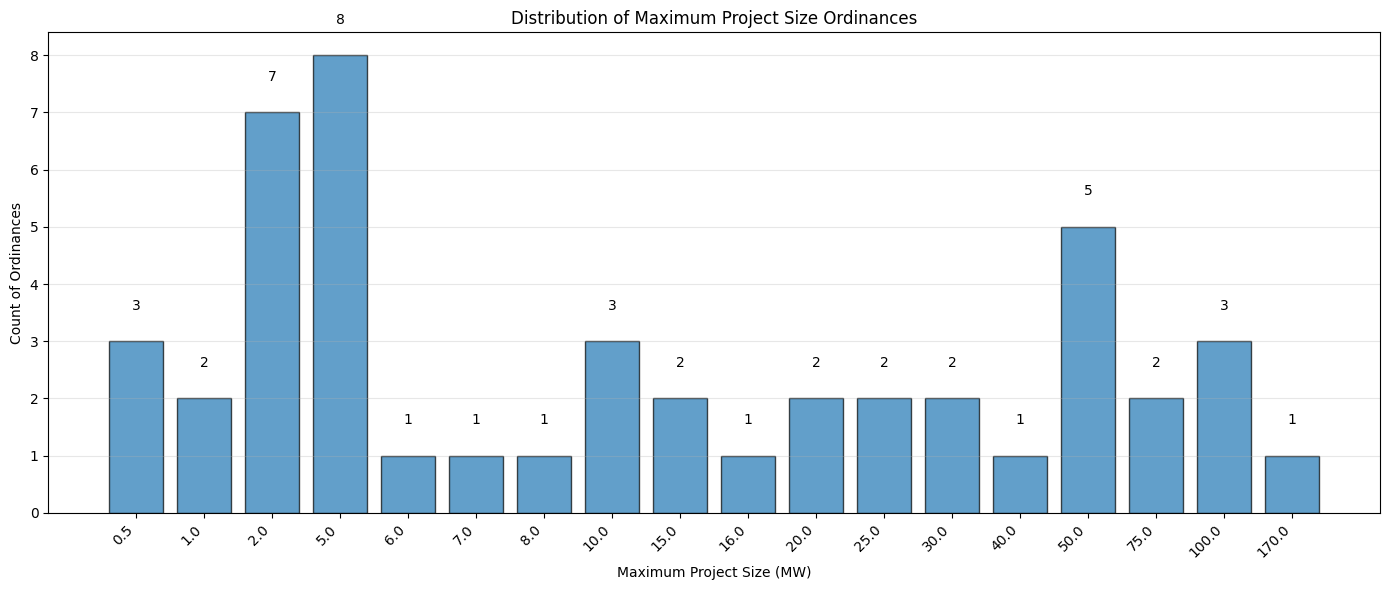

Maximum Project Size ordinances: 47
Mean: 25.8 MW
Median: 10.0 MW
Min: 0.5 MW
Max: 170.0 MW
Standard deviation: 35.5 MW
10th percentile: 1.6 MW
25th percentile: 3.5 MW
50th percentile: 10.0 MW
75th percentile: 35.0 MW
90th percentile: 75.0 MW

In [20]:
# Plot histogram of Maximum Project Size
max_project_data = usable_ord[usable_ord['Feature'] == 'Maximum Project Size']

# Collect statistics for printing later
project_stats = []

if len(max_project_data) > 0:
    # Get the values and convert to numeric
    project_values = pd.to_numeric(max_project_data['Value'], errors='coerce')
    
    # Create bar plot with value counts
    value_counts = project_values.value_counts().sort_index()
    
    plt.figure(figsize=(14, 6))
    # Use range for equal spacing, then set custom labels
    x_positions = range(len(value_counts))
    bars = plt.bar(x_positions, value_counts.values, edgecolor='black', alpha=0.7)
    plt.xlabel('Maximum Project Size (MW)')
    plt.ylabel('Count of Ordinances')
    plt.title('Distribution of Maximum Project Size Ordinances')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on top of bars
    for i, count in enumerate(value_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    # Set x-axis labels to show the actual MW values
    plt.xticks(x_positions, value_counts.index, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Collect summary statistics
    project_stats.append(f"Maximum Project Size ordinances: {len(max_project_data)}")
    project_stats.append(f"Mean: {project_values.mean():.1f} MW")
    project_stats.append(f"Median: {project_values.median():.1f} MW")
    project_stats.append(f"Min: {project_values.min():.1f} MW")
    project_stats.append(f"Max: {project_values.max():.1f} MW")
    project_stats.append(f"Standard deviation: {project_values.std():.1f} MW")
    project_stats.append(f"10th percentile: {project_values.quantile(0.10):.1f} MW")
    project_stats.append(f"25th percentile: {project_values.quantile(0.25):.1f} MW")
    project_stats.append(f"50th percentile: {project_values.quantile(0.50):.1f} MW")
    project_stats.append(f"75th percentile: {project_values.quantile(0.75):.1f} MW")
    project_stats.append(f"90th percentile: {project_values.quantile(0.90):.1f} MW")
else:
    project_stats.append("No Maximum Project Size ordinances found in the data.")

# Print all statistics together
if project_stats:
    print("\n".join(project_stats))

***Lot Size***

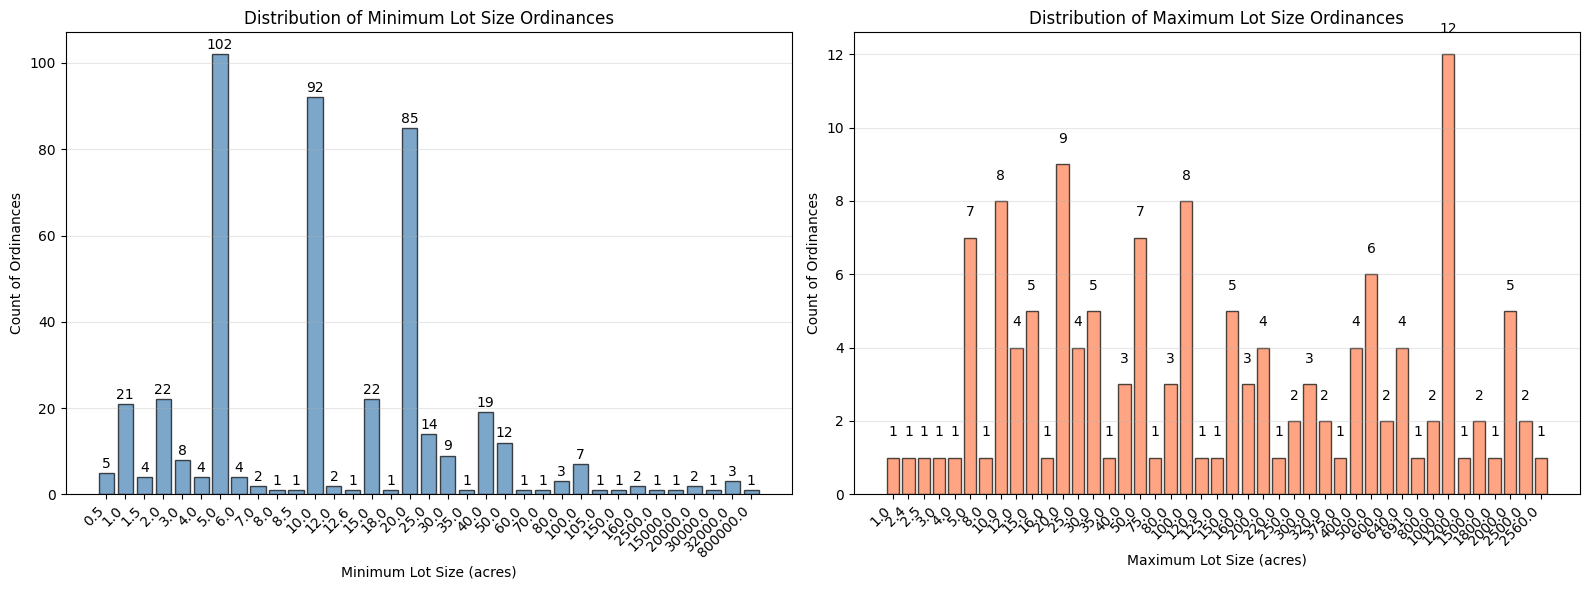

Minimum Lot Size ordinances: 457
Mean: 2168.1 acres
Median: 10.0 acres
Min: 0.5 acres
Max: 800000.0 acres
Standard deviation: 37546.9 acres

Maximum Lot Size ordinances: 138
Mean: 387.3 acres
Median: 100.0 acres
Min: 1.0 acres
Max: 2560.0 acres
Standard deviation: 586.3 acres

In [19]:
# Plot side-by-side histograms of Minimum and Maximum Lot Size ordinances
min_lot_data = usable_ord[usable_ord['Feature'] == 'Minimum Lot Size']
max_lot_data = usable_ord[usable_ord['Feature'] == 'Maximum Lot Size']

# Collect statistics for printing later
min_stats = []
max_stats = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Minimum Lot Size plot
if len(min_lot_data) > 0:
    min_lot_values = pd.to_numeric(min_lot_data['Value'], errors='coerce')
    min_value_counts = min_lot_values.value_counts().sort_index()
    
    x_positions = range(len(min_value_counts))
    ax1.bar(x_positions, min_value_counts.values, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.set_xlabel('Minimum Lot Size (acres)')
    ax1.set_ylabel('Count of Ordinances')
    ax1.set_title('Distribution of Minimum Lot Size Ordinances')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on top of bars
    for i, count in enumerate(min_value_counts.values):
        ax1.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    # Set x-axis labels
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(min_value_counts.index, rotation=45, ha='right')
    
    # Collect summary statistics
    min_stats.append(f"Minimum Lot Size ordinances: {len(min_lot_data)}")
    min_stats.append(f"Mean: {min_lot_values.mean():.1f} acres")
    min_stats.append(f"Median: {min_lot_values.median():.1f} acres")
    min_stats.append(f"Min: {min_lot_values.min():.1f} acres")
    min_stats.append(f"Max: {min_lot_values.max():.1f} acres")
    min_stats.append(f"Standard deviation: {min_lot_values.std():.1f} acres")
else:
    ax1.text(0.5, 0.5, 'No Minimum Lot Size\nordinances found', 
             ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('Distribution of Minimum Lot Size Ordinances')

# Maximum Lot Size plot
if len(max_lot_data) > 0:
    max_lot_values = pd.to_numeric(max_lot_data['Value'], errors='coerce')
    max_value_counts = max_lot_values.value_counts().sort_index()
    
    x_positions = range(len(max_value_counts))
    ax2.bar(x_positions, max_value_counts.values, edgecolor='black', alpha=0.7, color='coral')
    ax2.set_xlabel('Maximum Lot Size (acres)')
    ax2.set_ylabel('Count of Ordinances')
    ax2.set_title('Distribution of Maximum Lot Size Ordinances')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on top of bars
    for i, count in enumerate(max_value_counts.values):
        ax2.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    # Set x-axis labels
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels(max_value_counts.index, rotation=45, ha='right')
    
    # Collect summary statistics
    max_stats.append(f"Maximum Lot Size ordinances: {len(max_lot_data)}")
    max_stats.append(f"Mean: {max_lot_values.mean():.1f} acres")
    max_stats.append(f"Median: {max_lot_values.median():.1f} acres")
    max_stats.append(f"Min: {max_lot_values.min():.1f} acres")
    max_stats.append(f"Max: {max_lot_values.max():.1f} acres")
    max_stats.append(f"Standard deviation: {max_lot_values.std():.1f} acres")
else:
    ax2.text(0.5, 0.5, 'No Maximum Lot Size\nordinances found', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Distribution of Maximum Lot Size Ordinances')

plt.tight_layout()
plt.show()

# Print all statistics together
if min_stats:
    print("\n".join(min_stats))
if max_stats:
    if min_stats:
        print()  # Add blank line between min and max stats
    print("\n".join(max_stats))

**Noise**

94% of the 330 are max dBA ordinances. We currently have the capability to apply noise thresholds for wind, but could likely be adapted to pv if required.

In [ ]:
noise = usable_ord[usable_ord['Feature']=='Noise']
noise = noise[noise['Units'] != 'dB above background'] 



In [32]:
# Plot histogram of noise ordinance levels
# Collect statistics for printing later
noise_stats = []

if len(noise) > 0:
    # Get the values and convert to numeric
    noise_values = pd.to_numeric(noise['Value'], errors='coerce')
    
    # # Create bar plot with value counts
    # value_counts = noise_values.value_counts().sort_index()
    
    # plt.figure(figsize=(14, 6))
    # # Use range for equal spacing, then set custom labels
    # x_positions = range(len(value_counts))
    # bars = plt.bar(x_positions, value_counts.values, edgecolor='black', alpha=0.7, color='green')
    # plt.xlabel('Noise Level (dBA)')
    # plt.ylabel('Count of Ordinances')
    # plt.title('Distribution of Noise Ordinance Levels (dBA)')
    # plt.grid(True, alpha=0.3, axis='y')
    
    # # Add value labels on top of bars
    # for i, count in enumerate(value_counts.values):
    #     plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    # # Set x-axis labels to show the actual dBA values
    # plt.xticks(x_positions, value_counts.index, rotation=45, ha='right')
    
    # plt.tight_layout()
    # plt.show()
    
    # Collect summary statistics (reversed percentiles since lower is more restrictive)
    noise_stats.append(f"Noise ordinances: {len(noise)}")
    noise_stats.append(f"Mean: {noise_values.mean():.1f} dBA")
    noise_stats.append(f"Median: {noise_values.median():.1f} dBA")
    noise_stats.append(f"Min (most restrictive): {noise_values.min():.1f} dBA")
    noise_stats.append(f"Max (least restrictive): {noise_values.max():.1f} dBA")
    noise_stats.append(f"Standard deviation: {noise_values.std():.1f} dBA")
    noise_stats.append(f"10th percentile (most restrictive): {noise_values.quantile(0.10):.1f} dBA")
    noise_stats.append(f"25th percentile: {noise_values.quantile(0.25):.1f} dBA")
    noise_stats.append(f"50th percentile: {noise_values.quantile(0.50):.1f} dBA")
    noise_stats.append(f"75th percentile: {noise_values.quantile(0.75):.1f} dBA")
    noise_stats.append(f"90th percentile (least restrictive): {noise_values.quantile(0.90):.1f} dBA")
else:
    noise_stats.append("No noise ordinances found in the data.")

# Print all statistics together
if noise_stats:
    print("\n".join(noise_stats))

Noise ordinances: 311
Mean: 49.6 dBA
Median: 50.0 dBA
Min (most restrictive): 8.0 dBA
Max (least restrictive): 85.0 dBA
Standard deviation: 9.4 dBA
10th percentile (most restrictive): 40.0 dBA
25th percentile: 45.0 dBA
50th percentile: 50.0 dBA
75th percentile: 55.0 dBA
90th percentile (least restrictive): 60.0 dBA

**Coverage**

95% are percent of lot area. We will need to determine what constitues a lot.

In [29]:
# Unit breakdown for Coverage ordinances
coverage_ordinances = usable_ord[usable_ord['Feature']=='Coverage']
unit_counts = coverage_ordinances['Units'].value_counts()

output_lines = [f"Total Coverage ordinances: {len(coverage_ordinances)}\n"]
output_lines.append("Units breakdown:")
for unit, count in unit_counts.items():
    percentage = (count / len(coverage_ordinances)) * 100
    output_lines.append(f"  {unit}: {count} ({percentage:.1f}%)")

print("\n".join(output_lines))

Total Coverage ordinances: 200

Units breakdown:
  percent of lot area: 189 (94.5%)
  acres: 5 (2.5%)
  percent of total jurisdiction land: 5 (2.5%)
  square feet per acre: 1 (0.5%)

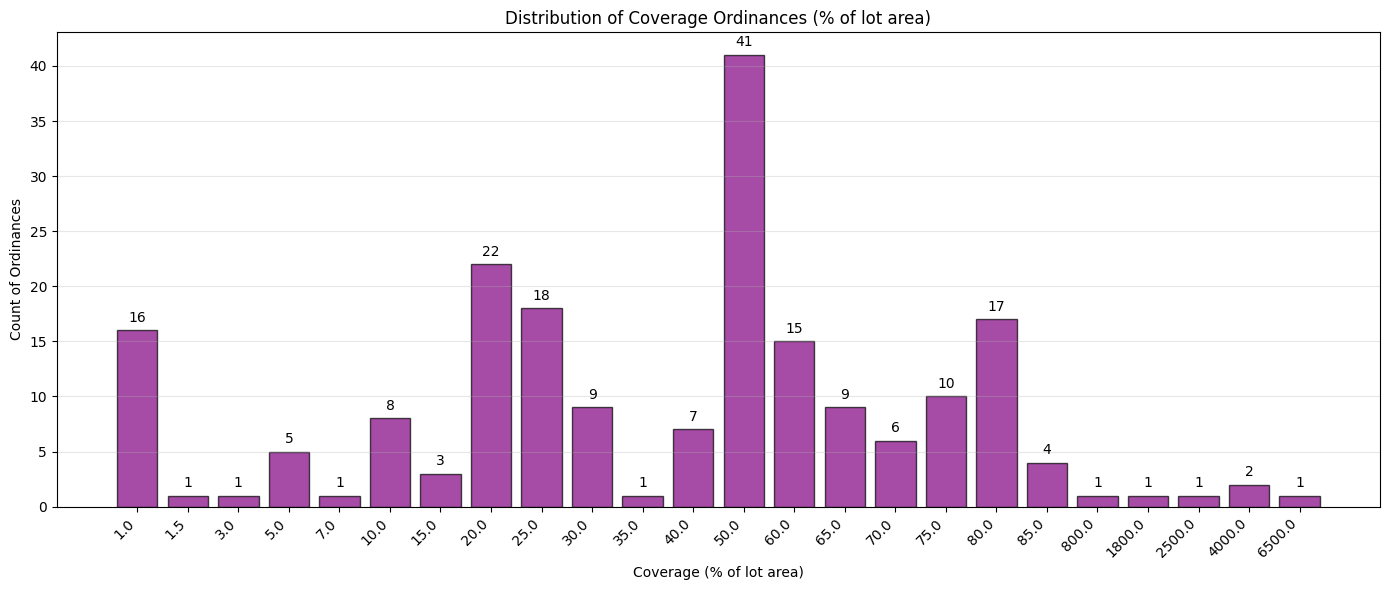

Coverage ordinances: 200
Mean: 138.3%
Median: 50.0%
Min (most restrictive): 1.0%
Max (least restrictive): 6500.0%
Standard deviation: 638.1%
10th percentile (most restrictive): 5.0%
25th percentile: 20.0%
50th percentile: 50.0%
75th percentile: 65.0%
90th percentile (least restrictive): 80.0%

In [30]:
# Plot histogram of Coverage (percent of lot area) ordinances
coverage_data = usable_ord[usable_ord['Feature'] == 'Coverage']

# Collect statistics for printing later
coverage_stats = []

if len(coverage_data) > 0:
    # Get the values and convert to numeric
    coverage_values = pd.to_numeric(coverage_data['Value'], errors='coerce')
    
    # Create bar plot with value counts
    value_counts = coverage_values.value_counts().sort_index()
    
    plt.figure(figsize=(14, 6))
    # Use range for equal spacing, then set custom labels
    x_positions = range(len(value_counts))
    bars = plt.bar(x_positions, value_counts.values, edgecolor='black', alpha=0.7, color='purple')
    plt.xlabel('Coverage (% of lot area)')
    plt.ylabel('Count of Ordinances')
    plt.title('Distribution of Coverage Ordinances (% of lot area)')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on top of bars
    for i, count in enumerate(value_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    # Set x-axis labels to show the actual percentage values
    plt.xticks(x_positions, value_counts.index, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Collect summary statistics (lower values are more restrictive)
    coverage_stats.append(f"Coverage ordinances: {len(coverage_data)}")
    coverage_stats.append(f"Mean: {coverage_values.mean():.1f}%")
    coverage_stats.append(f"Median: {coverage_values.median():.1f}%")
    coverage_stats.append(f"Min (most restrictive): {coverage_values.min():.1f}%")
    coverage_stats.append(f"Max (least restrictive): {coverage_values.max():.1f}%")
    coverage_stats.append(f"Standard deviation: {coverage_values.std():.1f}%")
    coverage_stats.append(f"10th percentile (most restrictive): {coverage_values.quantile(0.10):.1f}%")
    coverage_stats.append(f"25th percentile: {coverage_values.quantile(0.25):.1f}%")
    coverage_stats.append(f"50th percentile: {coverage_values.quantile(0.50):.1f}%")
    coverage_stats.append(f"75th percentile: {coverage_values.quantile(0.75):.1f}%")
    coverage_stats.append(f"90th percentile (least restrictive): {coverage_values.quantile(0.90):.1f}%")
else:
    coverage_stats.append("No Coverage ordinances found in the data.")

# Print all statistics together
if coverage_stats:
    print("\n".join(coverage_stats))

#### Misc. Analysis

**Unit Analysis**

This is the original data set units, and is meant to inform above analyses.

In [27]:
# For each ordinance type (Feature), display unique units and their counts within usable ordinances
output_lines = ["Units and counts for each ordinance feature type (usable ordinances only):\n"]

for feature in sorted(usable_ord.Feature.unique()):
    feature_data = usable_ord[usable_ord.Feature == feature]
    unit_counts = feature_data.Units.value_counts()
    
    output_lines.append(f"Feature: {feature}")
    output_lines.append(f"Total ordinances: {len(feature_data)}")
    output_lines.append("Units breakdown:")
    for unit, count in unit_counts.items():
        percentage = (count / len(feature_data)) * 100
        output_lines.append(f"  {unit}: {count} ({percentage:.1f}%)")
    output_lines.append("-" * 60)

# Print all output at once
print("\n".join(output_lines))

Units and counts for each ordinance feature type (usable ordinances only):

Feature: Coverage
Total ordinances: 200
Units breakdown:
  percent of lot area: 189 (94.5%)
  acres: 5 (2.5%)
  percent of total jurisdiction land: 5 (2.5%)
  square feet per acre: 1 (0.5%)
------------------------------------------------------------
Feature: Maximum Height
Total ordinances: 808
Units breakdown:
  feet: 808 (100.0%)
------------------------------------------------------------
Feature: Maximum Lot Size
Total ordinances: 138
Units breakdown:
  acres: 138 (100.0%)
------------------------------------------------------------
Feature: Maximum Project Size
Total ordinances: 47
Units breakdown:
  MW: 40 (85.1%)
  MW (AC): 5 (10.6%)
  MW (DC): 2 (4.3%)
------------------------------------------------------------
Feature: Minimum Lot Size
Total ordinances: 457
Units breakdown:
  acres: 449 (98.2%)
  square feet: 8 (1.8%)
------------------------------------------------------------
Feature: Noise
Total ordinances: 330
Units breakdown:
  dBA: 306 (92.7%)
  dB above background: 19 (5.8%)
  dB: 4 (1.2%)
  dBC: 1 (0.3%)
------------------------------------------------------------
Feature: Other Secs
Total ordinances: 36
Units breakdown:
  miles: 26 (72.2%)
  feet: 10 (27.8%)
------------------------------------------------------------
Feature: Panel Spacing
Total ordinances: 2
Units breakdown:
  feet: 2 (100.0%)
------------------------------------------------------------
Feature: Property Line (Non-Participating)
Total ordinances: 954
Units breakdown:
  feet: 934 (97.9%)
  structure-height-multiplier: 19 (2.0%)
  miles: 1 (0.1%)
------------------------------------------------------------
Feature: Property Line (Participating)
Total ordinances: 17
Units breakdown:
  feet: 17 (100.0%)
------------------------------------------------------------
Feature: Public Conservation Lands
Total ordinances: 61
Units breakdown:
  feet: 57 (93.4%)
  miles: 4 (6.6%)
------------------------------------------------------------
Feature: Railroads
Total ordinances: 21
Units breakdown:
  feet: 21 (100.0%)
------------------------------------------------------------
Feature: Roads
Total ordinances: 527
Units breakdown:
  feet: 509 (96.6%)
  structure-height-multiplier: 16 (3.0%)
  miles: 2 (0.4%)
------------------------------------------------------------
Feature: Structures (Non-Participating)
Total ordinances: 608
Units breakdown:
  feet: 595 (97.9%)
  miles: 7 (1.2%)
  structure-height-multiplier: 6 (1.0%)
------------------------------------------------------------
Feature: Structures (Participating)
Total ordinances: 18
Units breakdown:
  feet: 17 (94.4%)
  structure-height-multiplier: 1 (5.6%)
------------------------------------------------------------
Feature: Transmission
Total ordinances: 27
Units breakdown:
  feet: 25 (92.6%)
  structure-height-multiplier: 2 (7.4%)
------------------------------------------------------------
Feature: Water
Total ordinances: 124
Units breakdown:
  feet: 118 (95.2%)
  miles: 5 (4.0%)
  dBA: 1 (0.8%)
------------------------------------------------------------